<a href="https://colab.research.google.com/github/mateus-miguel/case-dadosfera/blob/main/EDA%20Visuals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install boto3

In [92]:
import os
import json
import boto3

# Chaves de acesso AWS

# Geramos um cliente S3 após definir as chaves de acesso do user IAM
s3 = boto3.client('s3')

bucket = 'dadosfera-datalake'
file_path = 'gold/products_enriched_5000rows.json'

# Obter JSON enriquecido dos produtos
obj = s3.get_object(
    Bucket=bucket,
    Key=file_path
)

dados = json.loads(obj["Body"].read())

               country  count
0        United States    668
1                China     32
2                Japan     21
3              Germany     19
4                Italy     15
5                India     11
6       United Kingdom     10
7            Australia     10
8          South Korea      8
9               Canada      7
10              France      7
11              Turkey      5
12         Switzerland      5
13               Spain      4
14              Mexico      4
15                Peru      4
16               Korea      2
17              Taiwan      2
18             Iceland      2
19              Norway      2
20         New Zealand      2
21               Egypt      2
22              Russia      2
23            Thailand      2
24           Indonesia      1
25             Vanuatu      1
26              Poland      1
27             Vietnam      1
28  Dominican Republic      1
29             Morocco      1


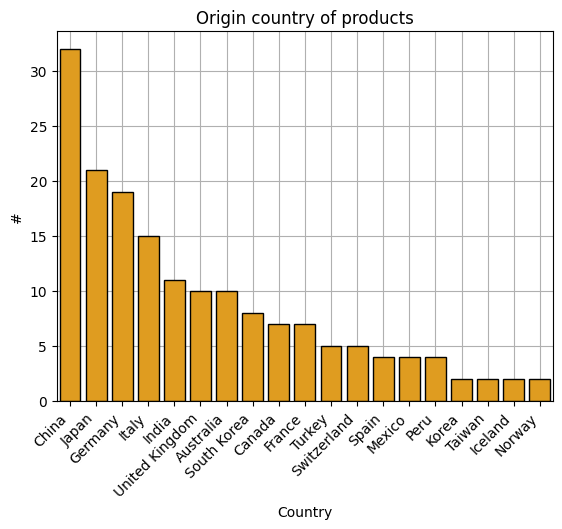

In [110]:
# --- CONTAGEM PAÍSES DE ORIGEM ---
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# Explorando a chave 'origin_country'
countries = []

for dado in dados:
  countries.append(dado['origin_country'])

# Filtrando '', 'null' e None
countries = list(filter(lambda x : x != None and x != '' and x != 'null' and x != 'Imported', countries))

# Normalização de alguns nomes de países
normalization = {
    'US': 'United States',
    'USA': 'United States',
    'North America': 'United States',
    'UK': 'United Kingdom',
    'England': 'United Kingdom',
    'Perù': 'Peru',
    'EU': None,
    'Europe': None,
    'East Asia': None,
    'Southeast Asia': None,
    'Central and South America': None
}

countries = [normalization.get(value, value) for value in countries]
# countries = [x.replace('United States', 'USA') for x in countries]

# print(countries)

# Pandas Series
counts = pd.Series(countries).value_counts().reset_index()
counts.columns = ['country', 'count']

print(counts.head(30))

# Criando gráfico de barras
sns.barplot(data=counts[1:20], x='country', y='count', color='orange', edgecolor='k', zorder=2)
plt.xticks(rotation=45, ha='right')
plt.title('Origin country of products')
plt.xlabel('Country')
plt.ylabel('#')
plt.grid(zorder=0)
plt.show()

Tamanho da lista de categorias: 6769
Quantidade de categorias geradas: 413
0.8197665829516916
            category  count
0      home & living   1744
1           clothing   1049
2        electronics    826
3             health    259
4               toys    236
5             beauty    192
6        accessories    177
7             sports    167
8   food & beverages    153
9         automotive    112
10           outdoor    100
11           jewelry     99
12   office supplies     83
13             tools     82
14              pets     79
15           kitchen     50
16     baby products     37
17       supplements     37
18            crafts     35
19             games     32
20              misc   1220


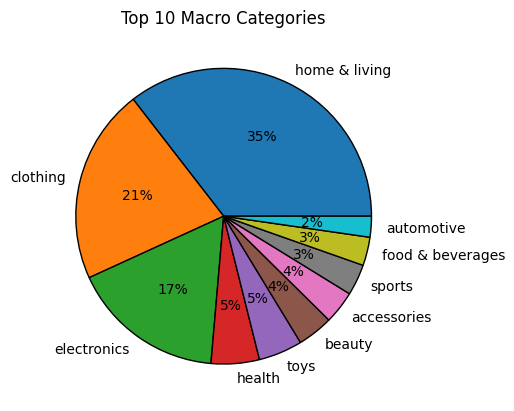

In [95]:
# --- CONTAGEM DAS CATEGORIAS ---

# Explorando a chave 'origin_country'
categories = []

for dado in dados:
  categories.append(dado['category'])

# Processo de flatten como cada item de categoria é uma lista de 1-2 categorias
categories = [item for sublist in categories for item in sublist]

print(f'Tamanho da lista de categorias: {len(categories)}')

# Processo de normalização (muitas categorias semelhantes)
normalization = {
    'home & living': {'home goods', 'home', 'homeware', 'home products'},
    'clothing': {'clothing', 'footwear', 'winter boots', 'beach sandals'},
    'electronics': {'electronics', 'electronic accessories'},
    'beauty': {'beauty', 'cosmetics', 'skincare', 'hair care'},
    'health': {'health', 'healthcare', 'health & personal care', 'personal care'},
    'sports': {'sports', 'sports equipment', 'fitness', 'exercise equipment'},
    'outdoor': {'outdoor', 'outdoors', 'outdoor gear', 'outdoor equipment', 'outdoor recreation'},
    'pets': {'pet care', 'pet supplies', 'pet food'},
    'food & beverages': {'food', 'food and beverage', 'food & beverage'}
}

# Invertendo a normalização para acessar itens da lista de categorias e converter a formas padrão/canônicas
inverse_normalization = {
    variant: canonical
    for canonical, variants in normalization.items()
    for variant in variants
}

# Aplicando a normalização para macro-categorias
normalized_categories = [
    inverse_normalization.get(category, category)
    for category in categories
]

# Pandas Series
counts = pd.Series(normalized_categories).value_counts().reset_index()
counts.columns = ['category', 'count']

print(f'Quantidade de categorias geradas: {counts['category'].size}')
print(counts['count'][0:20].sum() / len(categories))

# Top 5 categorias = 55.38% do total
# Top 10 categorias = 64.56% do total
# Top 20 categorias = 76.33% do total (> 80% já é um ótimo agrupamento, o resto é uma cauda longa)

# Após normalização: Top 20 = 81.71% do total (excelente)

# Reunindo categorias menores ou micro-categorias como 'misc' e mantendo top 20 categorias
top_n = 20

top = counts.iloc[:top_n].copy()
rest = counts.iloc[top_n:]

misc_row = pd.DataFrame({
    'category': ['misc'],
    'count': [rest['count'].sum()]
})

grouped_count = pd.concat([top, misc_row], ignore_index=True)

print(grouped_count.head(21))

plt.pie(grouped_count['count'][0:10], labels=grouped_count['category'][0:10], wedgeprops={'edgecolor': 'k', 'antialiased': True}, autopct='%.0f%%')
plt.title('Top 10 Macro Categories')
plt.show()

In [ ]:
# --- CLASSIFICAÇÃO DE MATERIAIS ---

# Chave 'material'
materials = []

for dado in dados:
  materials.append(dado['material'])

materials_clean = list(filter(lambda x: x != '' and x != 'null' and x!= None, materials))
print(materials_clean)

# São vários tipos de materiais, metais, plásticos, tecidos, alguns simples, compostos ou mistos. São várias formas de organizar.

['PU Leather', 'cotton', '304 Stainless Steel', '95% Rayon, 5% Spandex', 'mesh', 'poly-cotton', '100% Nylon', 'aluminum', 'rosewood', 'POLYESTER95% SPANDEX5%', 'Aluminium', '304 stainless steel, borosilicate glass', 'mesh', '100% lightweight polyester fabric', 'stainless steel', 'stainless steel', 'poly-cotton blend', 'Tritan Co-polyester, PP 05, Food-grade Silicone', 'stainless steel', 'plastic', 'die-cast aluminum', 'cardstock', 'lace', 'cotton', '100% cotton burlap', 'plastic', 'Cotton', 'glass', '1095HC steel, American Hickory, leather', 'paper', '100% Fabric', 'cast iron', 'hemp', 'natural ingredients', 'velvet', 'paper', 'designer resin', 'cotton', 'PVC', 'cranberry extract', 'durable materials', 'Oxford Cloth, PVC', '100% Cotton', 'Polyester/ Acrylic', 'paper', 'Three Layer Solid Straw', 'copper', 'European steel', 'linen', 'neoprene', 'faux leather', 'food grade silicone', 'leather', 'silicone', 'wood', 'bamboo', 'BPA free, food grade materials', 'copper', 'velvet', 'Metal + El

['1 year', '30 days', '10 years', '1 year', '2 years', 'lifetime', '1 year', 'lifetime', '3 years', '2 years', '1 year', '5 years', 'lifetime', '1 year', '1 year', '1 year', '1 year', '2 years', '5 years', 'lifetime', '1 year', '2 years', '30 days', None, 'lifetime', '1 year', '1 year', '5 years', '1 year', '5 years', 'lifetime', '1 year', 'lifetime', '1 year', '2 years', '2 years', '1 year', 'lifetime', '30 days', 'lifetime', '2 years', '1 year', '30 days', 'lifetime', '3 months', '1 year', '1 year', '30 days', '1 year', '3 years', 'lifetime', '3 years', '3 years', 'lifetime', '1 year', None, '10 years', '2 years', '1 year', '3 months', '1 year', 'lifetime', '3 years', None, 'lifetime', '2 years', 'lifetime', '5 years', '2 years', 'lifetime', '2 years', '30 days', '30 days', '5 years', None, '8 years', '18 months', '1 year', '1 year', '1 year', '1 year', '2 months', '3 months', '30 days', '30 days', '5 years', '1 year', 'lifetime', '1 year', None, '18 months', None, '5 years', None, '

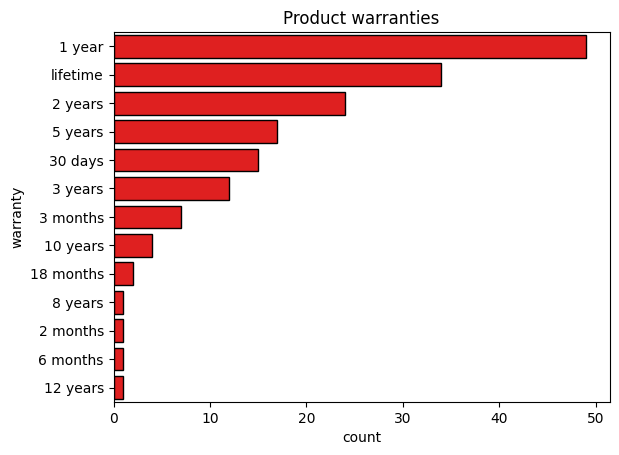

In [111]:
# --- CLASSIFICAÇÃO DE GARANTIAS ---

# Chave 'warranty'
warranties = []

for dado in dados:
  warranties.append(dado['warranty'])

# print(warranties)

# É preciso filtrar nulos '', None, 'null' e []
warranties_clean = list(filter(lambda x: x != '' and x!= None and x != 'null' and x != [] and x != [ 'null'], warranties))
warranties_unpack = [value[0] for value in warranties_clean]

# Normalização básica
normalization = {
    'lifetime': {
        'Lifetime',
        'lifetime guarantee',
        'Lifetime Warranty',
        'Lifetime Limited Warranty',
        'limited lifetime warranty',
        'Limited Lifetime Warranty',
        'Limited Lifetime Guarantee',
        'limited lifetime',
        'Lifetime Replacement',
        'lifetime maintenance service',
        'lifetime replacement warranty'
    },
    '30 days': {
        '30-Day Money Back Guarantee',
        '30-Day',
        '30-Day Warranty',
        '30 days money-back',
        '30-day money-back guarantee',
        '30 days money back guarantee',
        '30 DAYS MONEY BACK',
        '30 Days Money Back Guarantee',
        '30 Day FULL MONEY BACK GUARANTEE',
        '30 Day money back guarantee'
    },
    '2 months': {'60-day money back guarantee'},
    '3 months': {'90 days'},
    '1 year': {
        '12 months',
        '12 Months',
        '12-Month',
        '365 day happiness promise',
        '1 Year Limited Warranty',
        '1 year Warranty Against Tarnish',
        '365 days money back guarantee'
    },
    '2 years': {'2 Year', '24 months', '2 years parts'},
    '3 years': {'3 Year', '3 year', '3-Year', '3 Year Limited Parts & Labor'},
    '5 years': {'5 year limited warranty', '5 Year Warranty'},
    '10 years': {'10 years on steel components', '10 year standard, 1 year non-prorated'},
    None: {
        '100% satisfaction guarantee',
        'million mile limited warranty',
        'factory warranty',
        'FREE REPLACEMENT',
        'No Warranty',
        'Limited Warranty',
        'limited warranty',
        '100-night trial',
        '15-year limited heat exchanger',
        'Money-Back Program',
        'money back guarantee',
        'US Version with Warranty',
        'Quality Assurance Guarantee',
        '100% money-back guarantee',
        'none'
    }
}

# Invertendo a normalização para facilitar
inverse_normalization = {
    variant: canonical
    for canonical, variants in normalization.items()
    for variant in variants
}

warranties_normalized = [inverse_normalization.get(value, value) for value in warranties_unpack]

print(warranties_normalized)

# Pandas Series
counts = pd.Series(warranties_normalized).value_counts().reset_index()
counts.columns = ['warranty', 'count']

print(counts)

sns.barplot(counts, x=counts['count'], y=counts['warranty'], color='red', edgecolor='k')
plt.title('Product warranties')
plt.xlabel('count')
plt.ylabel('warranty')
plt.show()